# Keyword Spotting: Conformer

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [1]:
! pip install wget

In [2]:
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py

File ‘models_utils.py’ already there; not retrieving.

File ‘plot_utils.py’ already there; not retrieving.

File ‘preprocessing_utils.py’ already there; not retrieving.



## Import

To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [3]:
! pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5872 sha256=d6b522e1cc8ab782de1b8a39e9175bc122506258bcdbed60f8d013dd0ec4c751
  Stored in directory: /root/.cache/pip/wheels/09/a1/04/08e2688d2562d8f9ff89e77c6ddfbf7268e07dae1a6f22455e
Successfully built python_speech_features


To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [4]:
! pip install PyWavelets

from pywt import dwt

To visualize neural network architectures we use the Python library [visualkeras](https://github.com/paulgavrikov/visualkeras).

In [5]:
! pip install visualkeras

import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 kB 58.5 MB/s eta 0:00:00


In [6]:
import os
import pathlib
import requests
import wget
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils

import preprocessing_utils
from preprocessing_utils import create_dataset, remove_file_starting_with

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [7]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
Version: 2.9.1


## 1 - Data loading
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [8]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = sorted(commands[mask])
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [10]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset


Encode target labels with value between 0 and n_commands-1.

In [11]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [12]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [13]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     10
9977   four  ad63d93c_n

#### 1.4.1 - Smoke test
We enable the possibility to perform some tests without loading the entire dataset by setting `smoke_test=True`. With this option the train, validation and test set are reduced to a fraction `smoke_test_frac` of elements. This can be useful to test if everything is working as intended before the full training, or if the current hardware is not powerful enough. 

In [14]:
smoke_test = False
smoke_test_frac = 0.2
smoke_test_threshold = 1000 # minimum length of reduced datasets

if smoke_test:
    len_min = smoke_test_frac * min(len(reference_df_train), len(reference_df_val), len(reference_df_test))
    if len_min < smoke_test_threshold:
        raise Exception(f'One of the reduced datasets would have a number of samples < {smoke_test_threshold}! Select a larger value for "smoke_test_frac".')
    else: 
        reference_df_train = reference_df_train.sample(frac=smoke_test_frac, replace=False)
        reference_df_val   = reference_df_val.sample(frac=smoke_test_frac, replace=False)
        reference_df_test  = reference_df_test.sample(frac=smoke_test_frac, replace=False)

In [15]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


#### 1.4.2 - Dataset distribution
Let's now plot the percentage of elements of each class in each set. 

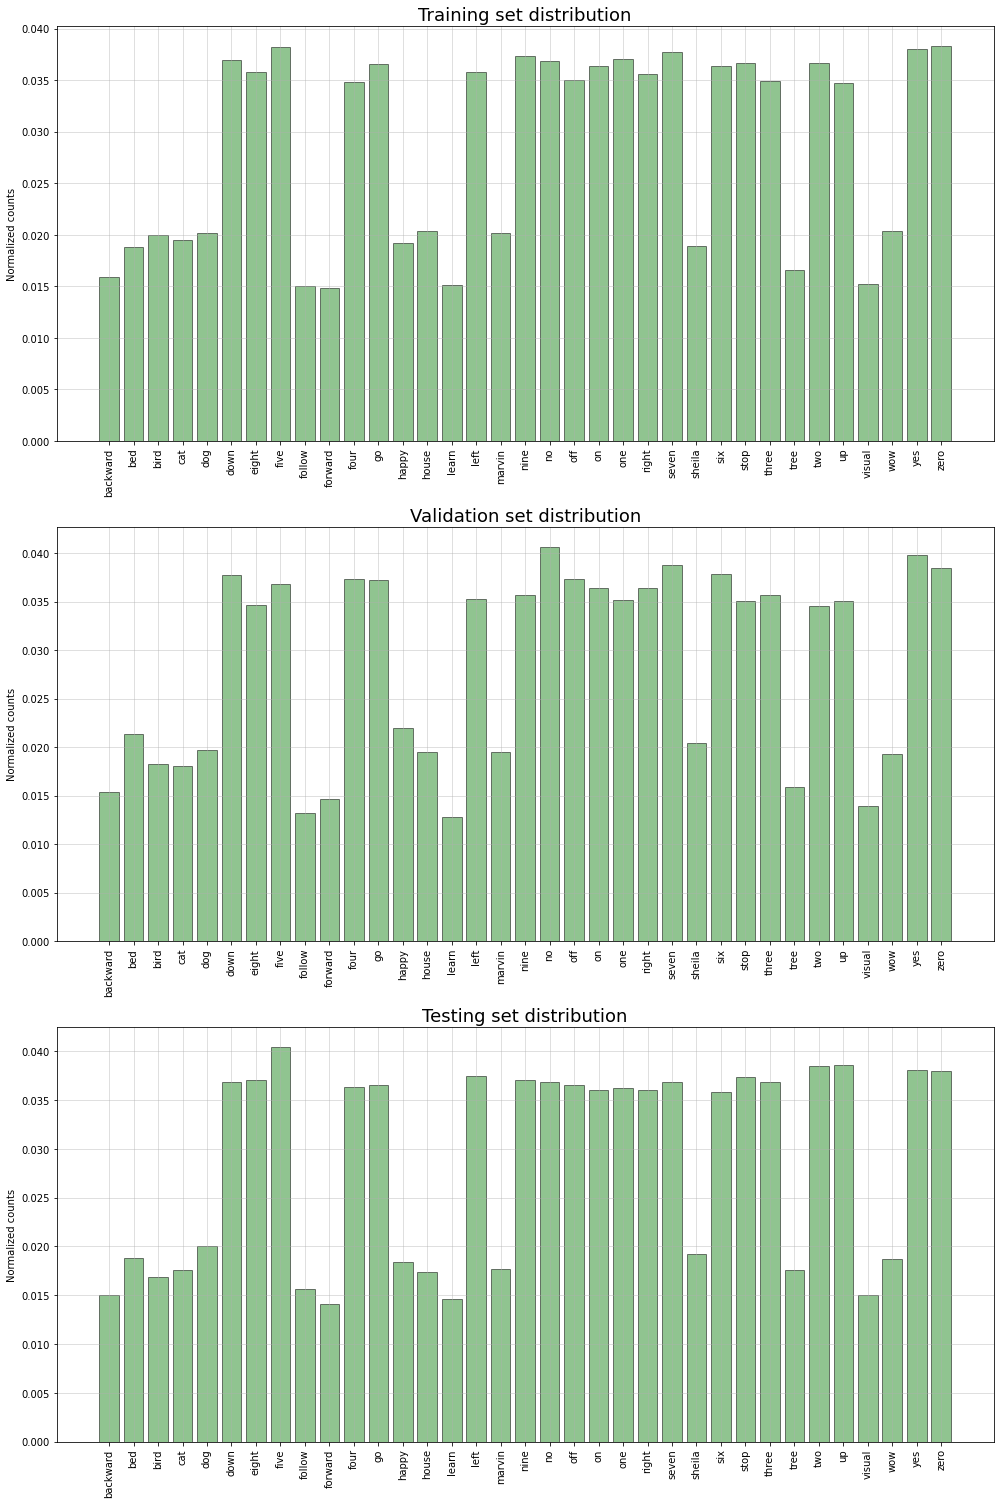

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

plot_utils.hist_class_distribution(reference_df_train, ax[0], commands)
plot_utils.hist_class_distribution(reference_df_val, ax[1], commands)
plot_utils.hist_class_distribution(reference_df_test, ax[2], commands)

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.5 Noise loading 
We load here the available noisy audio signals and we defined the object `noise_dict`, which is required by the function `load_and_preprocessing_data` (see next section).

In [17]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

/notebooks/preprocessing_utils.py:70: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. 

### 2.1 Loading and preprocessing
First, to load and preprocess the data, we use the function `load_and_preprocess_data`, defined in the file `preprocessing_utils.py`. This function puts together all loading and preprocessing methods that can be explored in the notebook `B1_data_analysis_and_preprocessing_inspection.ipynb`. 



In [18]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path):

    # load data
    data = load_data(file_name, file_label, data_path_=data_path_)
    
    # padding/trimming
    data = padding_trimming(data)
        
    # TensorFlow takes as input 32-bit floating point data
    return data.astype(np.float32)



### 2.2 - Dataset definition
We now use the function `create_dataset`, defined in the file `preprocessing_utils.py`. This function initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [19]:
print(inspect.getsource(preprocessing_utils.create_dataset))

def create_dataset(df, is_train=True, data_path_=data_path, cache_file=None, shuffle=True, apply_random_shift=False, apply_background_noise=False, noise_dict=None, noise_reduction=0.5, features=1, batch_size=32):
    '''
    features:
    - 1 for MFCC features [delta_order=2] (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features [delta_order=0]
    - 6 for log Mel-filterbank energy features [winlen=32, winstep=15.5, nfilt=64]
    - 7 for log Mel-filterbank energy features [winlen=25, winstep=8,    nfilt=80]
    '''

    # Convert DataFrame to lists
    file_names  = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the "load_and_preprocess_data" function
    dataset = dataset.map(lambda file_name, file_label: (tf.numpy_function(load_and_preprocess_data, [

### 2.3 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).


In [21]:
'''
    features_to_extract:
    - 1 for MFCC features [delta_order=2] (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features [delta_order=0]
    - 6 for log Mel-filterbank energy features [winlen=32, winstep=15.5, nfilt=64]
    - 7 for log Mel-filterbank energy features [winlen=25, winstep=8,    nfilt=80]
    else the original signal without feature extraction is returned
'''

apply_bn = True
noise_red = 0.5
features_to_extract = 2
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train,
    is_train=True,
    cache_file='train_cache',
    shuffle=True,
    apply_background_noise=apply_bn,
    noise_dict=noise_dict,
    noise_reduction=noise_red,
    features=features_to_extract,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    is_train=False,
    cache_file='val_cache',
    shuffle=True,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# important! shuffle=False
test_dataset, test_steps = create_dataset(
    reference_df_test,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

## 3 - Conformer model

References:
- [Conformer: Convolution-augmented Transformer for Speech Recognition | Google](https://arxiv.org/abs/2005.08100)
- [Fake Speech Detection: Conformer [TF] | Kaggle](https://www.kaggle.com/code/awsaf49/fake-speech-detection-conformer-tf)
- [audio_classification_models | GitHub](https://github.com/awsaf49/audio_classification_models)

This model combines **Convolutional Neural Networks** and **Transformers** to get the best of both worlds by modeling both local and global features of an audio sequence in a parameter-efficient way.
We will use only the **Encoder** part of the model.
The main components of the **Conformer-Block** are the following:

- **Feed-forward module**: simple fully connected layer to map $n$ inputs to $m$ outputs
- **Self-attention module**: compute globally coherent features
- **Convolution module**: compute locally coherent features using `pointwise conv` and `1d depth-wise conv`
- **Layer normalization module**: unlike batch normalization, it directly estimates the normalization statistics from the summed inputs to the neurons within a hidden layer

In [22]:
! pip install audio_classification_models

  Attempting uninstall: six
    Found existing installation: six 1.14.0
    Uninstalling six-1.14.0:
      Successfully uninstalled six-1.14.0


In [23]:
from audio_classification_models import ConformerEncoder

from tensorflow.keras.layers import Input, Reshape, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### 3.1 - Model definition


In [24]:
def conformer(input_shape=(99, 40), pooling='avg', output_shape=35, final_activation='softmax', name='conformer', **kwargs):
    
    inp = Input(shape=input_shape)
    out = Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1))(inp)
    out = ConformerEncoder(**kwargs)(out)
    
    if   pooling == 'avg':
        out = GlobalAveragePooling1D()(out)
    elif pooling == 'max':
        out = GlobalMaxPool1D()(out)
    else:
        raise ValueError("'pooling' must be either 'avg' or 'max'")

    out = Dense(output_shape, activation=final_activation)(out)
    
    model = Model(inputs=inp, outputs=out, name=name)
    
    return model

In [25]:
features_to_input = { # input shapes
    1 : (99, 39),     # MFCC features, delta_order=2
    2 : (99, 40),     # log Mel-filterbank energy features
    3 : (98, 257),    # spectrogram
    4 : (49, 39),     # Discrete Wavelet Transform + MFCC features
    5 : (99, 13)      # MFCC features, delta_order=0
}

input_shape     = features_to_input[features_to_extract]
num_blocks      = 1 # number of conformer blocks
pooling         = 'avg'
output_shape    = 35
final_activation = 'softmax'
model_name      = f'conformer_F{features_to_extract}_N{num_blocks}_P{pooling}'

model = conformer(input_shape, pooling, output_shape, final_activation, model_name, num_blocks=num_blocks)
model.summary()

Model: "conformer_F2_N1_Pavg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99, 40)]          0         
                                                                 
 reshape (Reshape)           (None, 99, 40, 1)         0         
                                                                 
 conformer_encoder (Conforme  (None, None, 144)        902448    
 rEncoder)                                                       
                                                                 
 global_average_pooling1d (G  (None, 144)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 35)                5075      
                                                                 
Total params: 907,523
Trainable params: 907,23

In [26]:
model.compile(
            optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
            loss      = "sparse_categorical_crossentropy",
            metrics   = "sparse_categorical_accuracy"
            )

In [27]:
# Show the structure of the model through building blocks
# tf.keras.utils.plot_model(model, to_file=f'{model_name}.png')
# Image(f'{model_name}.png')

### 3.2 - Model training 

In [28]:
# uncomment to remove cache files
# remove_file_starting_with('train_cache')

In [29]:
num_epochs = 100

early_stopping   = EarlyStopping(monitor='val_loss', patience=10)
reduce_LR        = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stopping, reduce_LR, model_checkpoint],
                verbose=1
                )

Epoch 1/100


2023-01-26 20:55:52.751686: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2650/2652 [============================>.] - ETA: 0s - loss: 2.5405 - sparse_categorical_accuracy: 0.2936

2023-01-26 20:58:05.738715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2652/2652 [==============================] - 768s 57ms/step - loss: 2.5399 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.6090 - val_sparse_categorical_accuracy: 0.5337 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 37s 14ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.5994 - val_loss: 1.0077 - val_sparse_categorical_accuracy: 0.7058 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 45s 17ms/step - loss: 1.0166 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.7796 - val_sparse_categorical_accuracy: 0.7703 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 40s 15ms/step - loss: 0.8321 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.7522 - val_sparse_categorical_accuracy: 0.7737 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 39s 15ms/step - loss: 0.7136 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.6406 - val_sparse_categorical_accuracy: 0.8052 - lr: 1.0000e-04
E

In [31]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,2.539878,0.293741,1.609006,0.533654,1.000000e-04
1,1.386816,0.599359,1.007731,0.705829,1.000000e-04
2,1.016639,0.703443,0.779604,0.770333,1.000000e-04
3,0.832103,0.755691,0.752220,0.773738,1.000000e-04
4,0.713571,0.788320,0.640585,0.805188,1.000000e-04
5,0.632327,0.810485,0.561768,0.832332,1.000000e-04
6,0.569445,0.828738,0.534445,0.840645,1.000000e-04
7,0.526616,0.841240,0.502872,0.851062,1.000000e-04
8,0.485371,0.853106,0.472932,0.861579,1.000000e-04
9,0.451288,0.863169,0.464399,0.857772,1.000000e-04


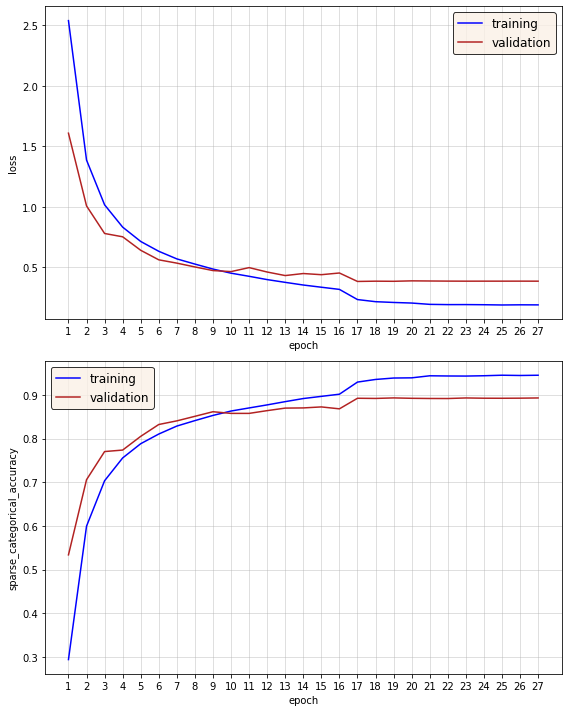

In [32]:
plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.

In [33]:
model.save(f'trained_models/{model_name}.h5')

### 3.3 - Validation metrics
Since the dataset is unbalanced (see histograms in section 1.4) and we have more than 2 classes, the accuracy is not a good metric. To have a good understanding of the classifier performance we must rely on other metrics.  

First we compute the output of the network for all data in the test set. To obtain it use:
```python 
    model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()
```
This is needed because the elements in `[len(val_labels):]` are not part of the dataset, but they are just added to complete the batch. 

Then we get the predicted label by computing the $argmax$ over the output of the network, for each input data. This is motivated by the fact that there are as many neurons as labels in the last layer of the network and we used the softmax activation function. 

343/344 [============================>.] - ETA: 0s

2023-01-26 21:17:11.019223: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


344/344 [==============================] - 99s 287ms/step


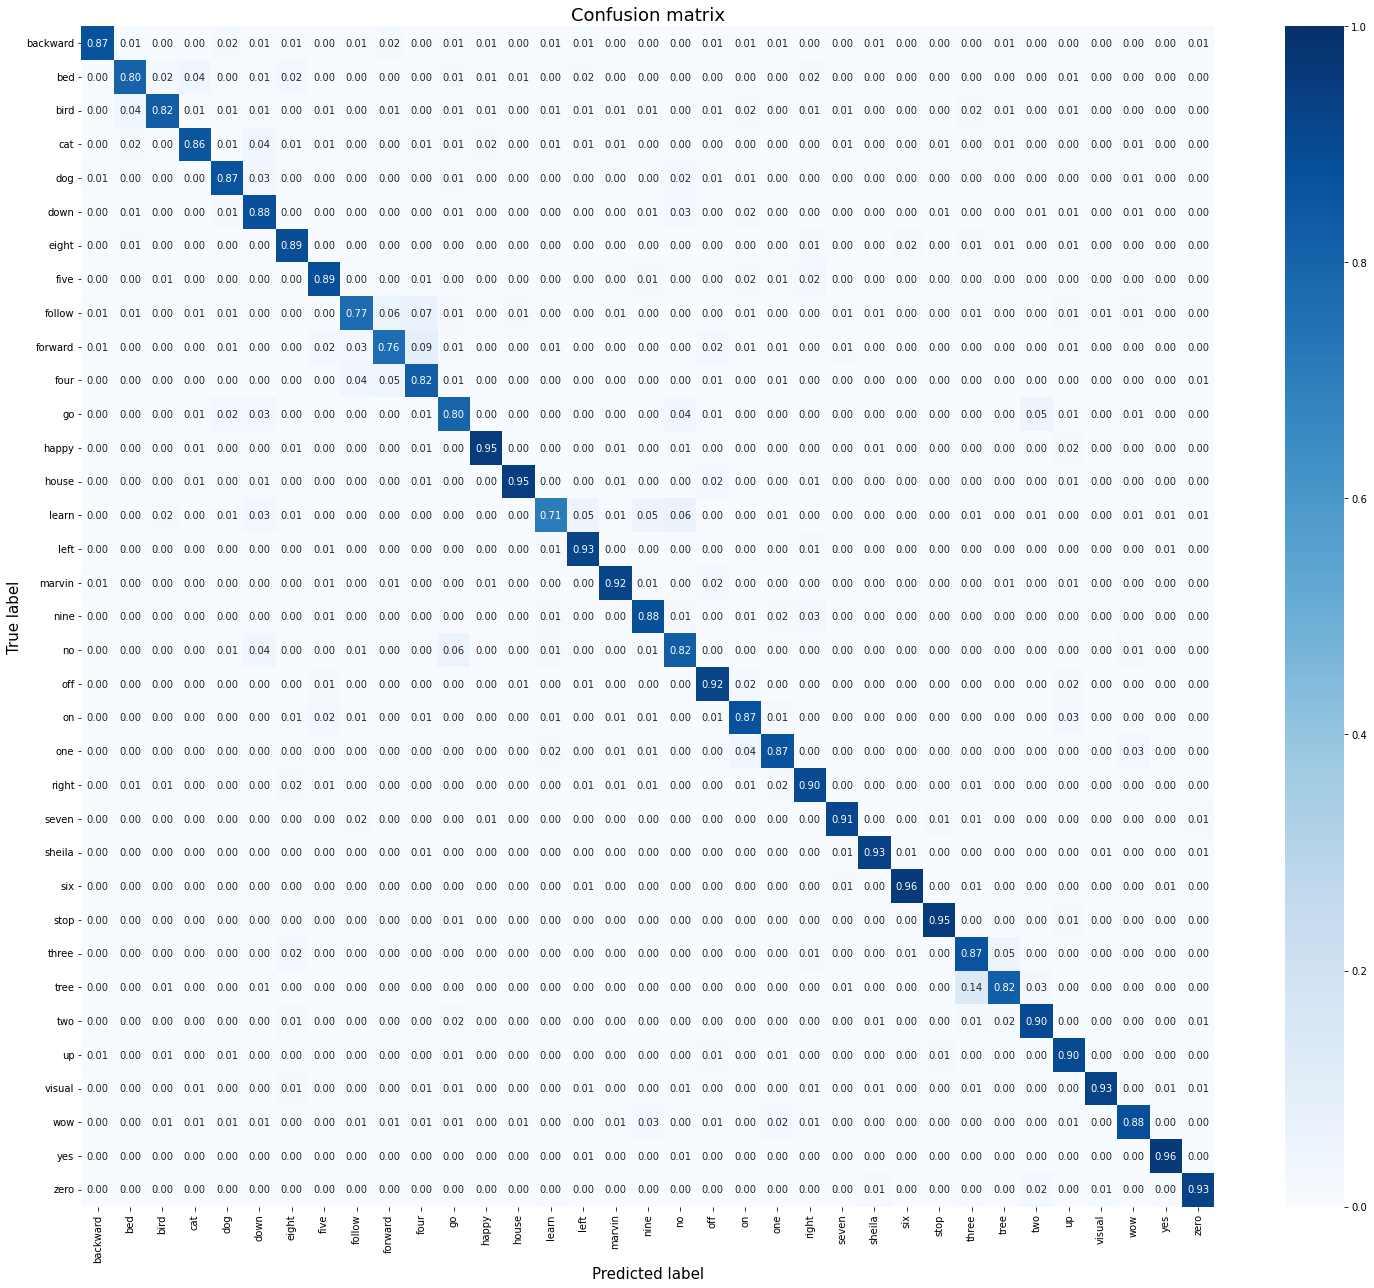

In [34]:
# true labels
y_true = reference_df_test['class'].tolist()

# get predictions for test set
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(y_true)].squeeze()

# predicted labels
y_pred = np.argmax(test_pred, axis=1)

# plot confusion matrix
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')

In [35]:
def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

# get metrics and display them 
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_modified = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_modified.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.8846,0.884,0.8841,0.884,0.4185,0.8801


## 4 - Hyperparameter tuning: Bayesian optimization with KerasTuner

### 4.1 - Import for BO

In [36]:
! pip install keras-tuner

import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 21.6 MB/s eta 0:00:00


### 4.2 - Define the search space

In [37]:
input_shape     = features_to_input[features_to_extract]
num_blocks      = 1 # number of conformer blocks
pooling         = 'avg'
output_shape    = 35
final_activation = 'softmax'

In [38]:
def build_model(hp):

    # search space
    sub_filters      = hp.Int("sub_filters",      128, 144, step=2) # 'sub_filters' must be even
    sub_kernel_size = hp.Int("sub_kernel_size",   2,   4)
    sub_strides     = hp.Int("sub_strides",       1,   2)
    head_size       = hp.Int("head_size",        16,  32)
    num_heads       = hp.Int("num_heads",         2,   6)
    kernel_size     = hp.Int("kernel_size",       2,  32)
    dropout         = hp.Float("dropout",        .1,  .5)
    
    # call existing model-building code with the hyperparameter values
    model = conformer(
                    input_shape,
                    pooling,
                    output_shape,
                    final_activation,
                    num_blocks  = num_blocks,
                    dmodel      = sub_filters,
                    head_size   = head_size,
                    num_heads   = num_heads,
                    kernel_size = kernel_size,
                    dropout     = dropout,
                    subsampling = {
                                'type'        : 'conv2d',
                                'filters'      : sub_filters,
                                'kernel_size' : sub_kernel_size,
                                'strides'     : sub_strides
                                },
                    )
    
    model.compile(
                optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss      = "sparse_categorical_crossentropy",
                metrics   = "sparse_categorical_accuracy"
                )
    
    return model

build_model(keras_tuner.HyperParameters())

### 4.3 - Start the search

In [39]:
tuner = keras_tuner.BayesianOptimization(
    
    hypermodel           = build_model,
    objective            = "val_sparse_categorical_accuracy",
    max_trials           = 20,
    seed                 = 1,
    max_model_size       = 2*10**6,
    directory            = "keras_tuner",
    project_name         = "conformer",
    overwrite            = False,
    executions_per_trial = 1
    
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project keras_tuner/conformer/oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner/conformer/tuner0.json
Search space summary
Default search space size: 7
sub_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 144, 'step': 2, 'sampling': None}
sub_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
sub_strides (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
head_size (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 1, 'sampling': None}
num_heads (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step'

In [40]:
num_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_LR      = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

tuner.search(
            train_dataset,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_data=val_dataset,
            validation_steps=val_steps,
            callbacks=[early_stopping, reduce_LR], 
            verbose=1
            )

INFO:tensorflow:Oracle triggered exit


### 4.4 - Query the results

In [41]:
tuner.results_summary()

Results summary
Results in keras_tuner/conformer
Showing 10 best trials
Trial summary
Hyperparameters:
sub_filters: 144
sub_kernel_size: 4
sub_strides: 1
head_size: 26
num_heads: 6
kernel_size: 32
dropout: 0.1
Score: 0.9155648946762085
Trial summary
Hyperparameters:
sub_filters: 144
sub_kernel_size: 4
sub_strides: 1
head_size: 29
num_heads: 4
kernel_size: 32
dropout: 0.1
Score: 0.9141626358032227
Trial summary
Hyperparameters:
sub_filters: 142
sub_kernel_size: 4
sub_strides: 1
head_size: 16
num_heads: 3
kernel_size: 32
dropout: 0.1
Score: 0.9126602411270142
Trial summary
Hyperparameters:
sub_filters: 134
sub_kernel_size: 4
sub_strides: 1
head_size: 32
num_heads: 6
kernel_size: 32
dropout: 0.1
Score: 0.911057710647583
Trial summary
Hyperparameters:
sub_filters: 144
sub_kernel_size: 4
sub_strides: 1
head_size: 16
num_heads: 6
kernel_size: 32
dropout: 0.1
Score: 0.9099559187889099
Trial summary
Hyperparameters:
sub_filters: 138
sub_kernel_size: 4
sub_strides: 1
head_size: 22
num_heads: 5


In [42]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "conformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99, 40)]          0         
                                                                 
 reshape (Reshape)           (None, 99, 40, 1)         0         
                                                                 
 conformer_encoder (Conforme  (None, None, 144)        1679352   
 rEncoder)                                                       
                                                                 
 global_average_pooling1d (G  (None, 144)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 35)                5075      
                                                                 
Total params: 1,684,427
Trainable params: 1,684,139
Non-t

## 5 - Best model: training and testing


### 5.1 - Best model definition

In [43]:
input_shape     = features_to_input[features_to_extract]
num_blocks      = 1 # number of conformer blocks
pooling         = 'avg'
output_shape    = 35
final_activation = 'softmax'
model_name      = 'conformer_best'

Get the best hyperparameters.

In [54]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'sub_filters': 144,
 'sub_kernel_size': 4,
 'sub_strides': 1,
 'head_size': 26,
 'num_heads': 6,
 'kernel_size': 32,
 'dropout': 0.1}

Build the model with the best hyperparameters.

In [55]:
model = build_model(best_hps)
model.summary()

Model: "conformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 99, 40)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 99, 40, 1)         0         
                                                                 
 conformer_encoder (Conforme  (None, None, 144)        1679352   
 rEncoder)                                                       
                                                                 
 global_average_pooling1d_1   (None, 144)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 35)                5075      
                                                                 
Total params: 1,684,427
Trainable params: 1,684,139
Non-t

### 5.2 - Best model training
At this point we can retrain the best model.

In [57]:
num_epochs = 100

early_stopping   = EarlyStopping(monitor='val_loss', patience=10)
reduce_LR        = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stopping, reduce_LR, model_checkpoint],
                verbose=1
                )

Epoch 1/100
2652/2652 [==============================] - 112s 40ms/step - loss: 2.4598 - sparse_categorical_accuracy: 0.3175 - val_loss: 1.7036 - val_sparse_categorical_accuracy: 0.5069 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 103s 39ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.6429 - val_loss: 1.0796 - val_sparse_categorical_accuracy: 0.6745 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 103s 39ms/step - loss: 0.8700 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.7928 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 106s 40ms/step - loss: 0.6920 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 105s 40ms/step - loss: 0.5811 - sparse_categorical_accuracy: 0.8296 - val_loss: 0.5558 - val_sparse_categorical_accuracy: 0.8323 - 

In [58]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,2.459834,0.317532,1.703555,0.506911,1.000000e-04
1,1.254921,0.642864,1.079622,0.674479,1.000000e-04
2,0.869983,0.748409,0.714230,0.792768,1.000000e-04
3,0.691984,0.798265,0.677187,0.794071,1.000000e-04
4,0.581096,0.829633,0.555790,0.832332,1.000000e-04
5,0.506432,0.850113,0.521259,0.847456,1.000000e-04
6,0.450740,0.865832,0.494467,0.859675,1.000000e-04
7,0.406323,0.878382,0.443582,0.868690,1.000000e-04
8,0.372093,0.888139,0.417256,0.881310,1.000000e-04
9,0.341315,0.896917,0.450788,0.873998,1.000000e-04


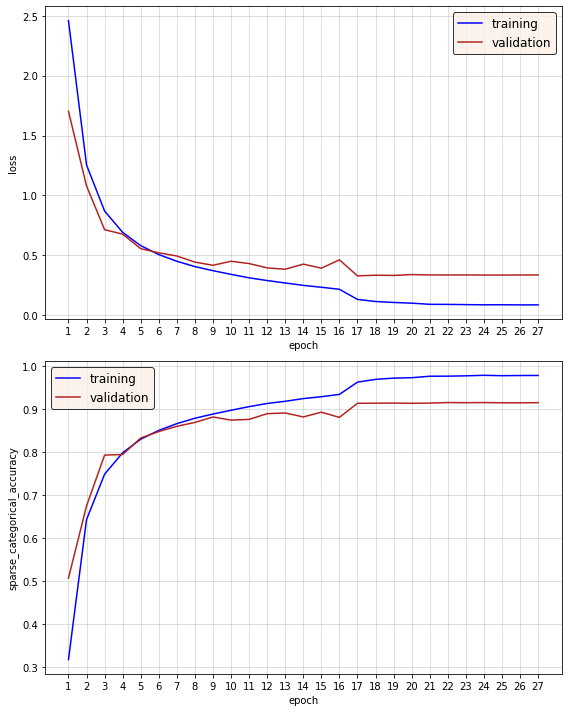

In [59]:
plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.

In [60]:
model.save(f'trained_models/{model_name}.h5')

### 5.3 - Validation metrics

In [61]:
# true labels
y_true = reference_df_test['class'].tolist()

# get predictions for test set
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(y_true)].squeeze()

# predicted labels
y_pred = np.argmax(test_pred, axis=1)

344/344 [==============================] - 5s 12ms/step


Plot the confusion matrix:

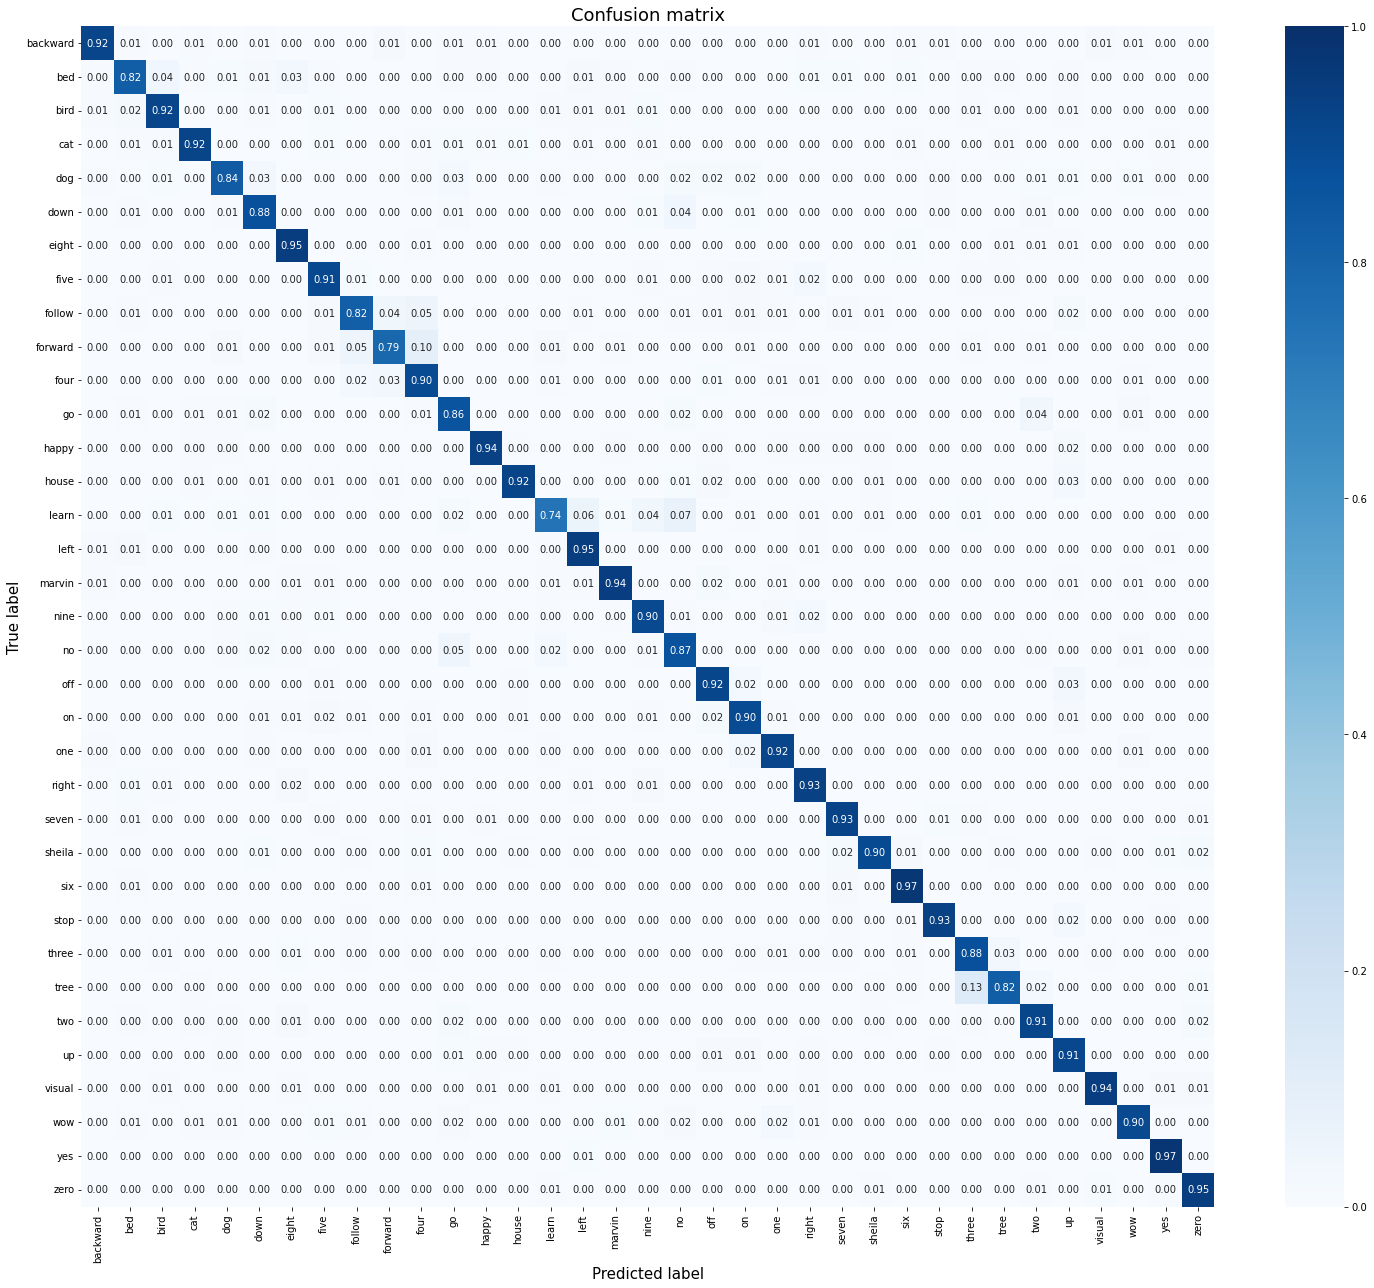

In [62]:
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')
# plt.savefig(f'figures/cm_{model_name}.png')

Evaluate some metrics:



In [63]:
# get metrics and display them
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)

In [64]:
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_simple = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_simple.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.9069,0.9062,0.9064,0.9062,0.3623,0.9031


# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.

**[Andrade18]** <br>
Andrade, D.C., Leo, S., Viana, M., & Bernkopf, C. (2018). _A neural attention model for speech command recognition_. ArXiv, abs/1808.08929.

**[Chorowski15]** <br>
Chorowski, J., Bahdanau, D., Serdyuk, D., Cho, K., & Bengio, Y. (2015). _Attention-Based Models for Speech Recognition_. ArXiv, abs/1506.07503.

**[Gulati20]** <br>
Gulati, A., Qin, J., Chiu, C., Parmar, N., Zhang, Y., Yu, J., Han, W., Wang, S., Zhang, Z., Wu, Y., & Pang, R. (2020). _Conformer: Convolution-augmented Transformer for Speech Recognition_. ArXiv, abs/2005.08100.

**[Dong18]** <br>
L. Dong, S. Xu and B. Xu, _Speech-Transformer: A No-Recurrence Sequence-to-Sequence Model for Speech Recognition_, 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Calgary, AB, Canada, 2018, pp. 5884-5888, doi: 10.1109/ICASSP.2018.8462506.